<a href="https://colab.research.google.com/github/StokedDude/quant-lab/blob/main/Personal_CIO_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏔️ Personal CIO System

**Regime-Based Capital Allocation for Systematic Traders**

---

## What This Does

**Not a stock picker. Not an alpha generator. A capital allocator.**

Decides **WHEN** to deploy capital based on market conditions.

### Mountain Biker's Translation

- **Regime Engine** = Trail conditions monitor
- **OFF** = Trail too sketchy, stay home
- **LIGHT** = Selective lines only  
- **ON** = Full send mode
- **Allocator** = How much gear to commit

---

## Quick Start

1. **Run all cells** (Runtime → Run all)
2. Review backtest results
3. Check current regime
4. Adjust parameters in Section 2
5. Re-run for your settings

**Total time**: 2-3 minutes

# Section 1: Installation (One Click)

Run this cell to install everything.

In [ ]:
# Install dependencies
!pip install -q yfinance pandas numpy matplotlib seaborn

print("✅ Installation complete!")
print("📊 Ready to run backtest...")

✅ Installation complete!
📊 Ready to run backtest...


# Section 2: Configuration

Adjust these parameters to match your risk tolerance.

In [ ]:
# ========================================
# REGIME THRESHOLDS
# ========================================
OFF_THRESHOLD = 0.35   # Below = RISK-OFF (stay in cash)
ON_THRESHOLD = 0.60    # Above = RISK-ON (full deployment)
HYSTERESIS_DAYS = 3    # Confirmation days (prevents whipsaw)

# ========================================
# ALLOCATION MAPPING
# ========================================
ALLOC_MAP = {
    "OFF": 0.00,      # 0% swing exposure
    "LIGHT": 0.30,    # 30% swing exposure
    "ON": 0.70,       # 70% swing exposure
}

# ========================================
# COSTS & PARAMETERS
# ========================================
RF_ANNUAL = 0.045              # 4.5% risk-free rate
TRANSACTION_COST_BPS = 5       # 5 bps trading cost
BACKTEST_START = "2010-01-01"  # Start date (2010 for faster download)

# Component parameters
TREND_MA_DAYS = 200
VIX_MEDIAN_DAYS = 252
VIX_BAND = 0.10
BREADTH_MA_DAYS = 200
BREADTH_BAND = 0.01
DRAWDOWN_LOOKBACK_DAYS = 60

print("✅ Configuration loaded")
print(f"\nRegime Thresholds:")
print(f"  OFF if score < {OFF_THRESHOLD}")
print(f"  LIGHT if {OFF_THRESHOLD} ≤ score ≤ {ON_THRESHOLD}")
print(f"  ON if score > {ON_THRESHOLD}")
print(f"\nAllocation:")
for state, weight in ALLOC_MAP.items():
    print(f"  {state:6s}: {weight*100:.0f}% swing / {(1-weight)*100:.0f}% cash")

✅ Configuration loaded

Regime Thresholds:
  OFF if score < 0.35
  LIGHT if 0.35 ≤ score ≤ 0.6
  ON if score > 0.6

Allocation:
  OFF   : 0% swing / 100% cash
  LIGHT : 30% swing / 70% cash
  ON    : 70% swing / 30% cash


# Section 3: Core System Code

The regime engine and allocator (no changes needed).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ========================================
# TECHNICAL INDICATORS
# ========================================

def sma(series, n):
    """Simple moving average."""
    return series.rolling(n).mean()

def drawdown_from_rolling_high(price, lookback):
    """Drawdown from rolling high."""
    rolling_high = price.rolling(lookback).max()
    return price / rolling_high - 1.0

# ========================================
# REGIME COMPONENTS
# ========================================

def compute_trend_score(prices):
    """Trend score: SPY & QQQ above 200DMA."""
    spy_200 = sma(prices["SPY"], TREND_MA_DAYS)
    qqq_200 = sma(prices["QQQ"], TREND_MA_DAYS)

    spy_above = (prices["SPY"] > spy_200).astype(int)
    qqq_above = (prices["QQQ"] > qqq_200).astype(int)

    return (spy_above + qqq_above) / 2.0

def compute_volatility_score(prices):
    """Volatility score: VIX vs median."""
    vix = prices["VIX"]
    vix_median = vix.rolling(VIX_MEDIAN_DAYS).median()
    band = VIX_BAND

    score = pd.Series(index=prices.index, dtype=float)
    score[vix < (1 - band) * vix_median] = 1.0
    score[(vix >= (1 - band) * vix_median) & (vix <= (1 + band) * vix_median)] = 0.5
    score[vix > (1 + band) * vix_median] = 0.0

    return score

def compute_breadth_score(prices):
    """Breadth score: RSP/SPY ratio."""
    ratio = prices["RSP"] / prices["SPY"]
    ratio_ma = sma(ratio, BREADTH_MA_DAYS)
    band = BREADTH_BAND

    score = pd.Series(index=prices.index, dtype=float)
    score[ratio > (1 + band) * ratio_ma] = 1.0
    score[(ratio >= (1 - band) * ratio_ma) & (ratio <= (1 + band) * ratio_ma)] = 0.5
    score[ratio < (1 - band) * ratio_ma] = 0.0

    return score

def compute_drawdown_score(prices):
    """Drawdown score: Recent SPY drawdown."""
    dd = drawdown_from_rolling_high(prices["SPY"], DRAWDOWN_LOOKBACK_DAYS)

    score = pd.Series(index=prices.index, dtype=float)
    score[dd > -0.05] = 1.0
    score[(dd <= -0.05) & (dd >= -0.10)] = 0.5
    score[dd < -0.10] = 0.0

    return score

def compute_risk_score(components):
    """Weighted risk score."""
    score = (
        0.35 * components["trend"]
        + 0.25 * components["vol"]
        + 0.25 * components["breadth"]
        + 0.15 * components["drawdown"]
    )
    return score.dropna()

def score_to_state(score):
    """Map score to state."""
    if score < OFF_THRESHOLD:
        return "OFF"
    if score <= ON_THRESHOLD:
        return "LIGHT"
    return "ON"

def apply_hysteresis(raw_state, confirm_days=HYSTERESIS_DAYS):
    """Apply N-day confirmation."""
    state = raw_state.copy()
    current = state.iloc[0]
    pending = None
    pending_count = 0

    for i in range(1, len(state)):
        s = raw_state.iloc[i]

        if s == current:
            pending = None
            pending_count = 0
            state.iloc[i] = current
            continue

        if pending is None or pending != s:
            pending = s
            pending_count = 1
        else:
            pending_count += 1

        if pending_count >= confirm_days:
            current = pending
            pending = None
            pending_count = 0

        state.iloc[i] = current

    return state

def run_regime_engine(prices):
    """Run complete regime analysis."""
    components = pd.DataFrame(index=prices.index)
    components["trend"] = compute_trend_score(prices)
    components["vol"] = compute_volatility_score(prices)
    components["breadth"] = compute_breadth_score(prices)
    components["drawdown"] = compute_drawdown_score(prices)

    risk_score = compute_risk_score(components)
    raw_state = risk_score.apply(score_to_state)
    final_state = apply_hysteresis(raw_state)

    result = components.loc[risk_score.index].copy()
    result["risk_score"] = risk_score
    result["state_raw"] = raw_state
    result["state"] = final_state

    return result

# ========================================
# ALLOCATOR
# ========================================

def target_weight_from_state(state):
    """Map state to target weight."""
    return state.map(ALLOC_MAP).astype(float)

def compute_portfolio_returns(asset_returns, target_weight, lag_days=1):
    """Compute portfolio returns with lag and costs."""
    rf_daily = (1.0 + RF_ANNUAL) ** (1.0 / 252) - 1.0

    w_lag = target_weight.shift(lag_days).fillna(0.0)
    port_ret = w_lag * asset_returns + (1.0 - w_lag) * rf_daily

    weight_changed = (target_weight.diff().fillna(0.0).abs() > 1e-9).astype(float)
    tc = weight_changed * (TRANSACTION_COST_BPS / 10000.0)

    return port_ret - tc

# ========================================
# PERFORMANCE METRICS
# ========================================

def equity_curve(returns):
    """Convert returns to equity curve."""
    return (1.0 + returns.fillna(0.0)).cumprod()

def drawdown_curve(equity):
    """Calculate drawdown from equity."""
    peak = equity.cummax()
    return equity / peak - 1.0

def perf_stats(returns):
    """Calculate performance statistics."""
    r = returns.dropna()
    if len(r) == 0:
        return {}

    eq = equity_curve(r)
    years = (eq.index[-1] - eq.index[0]).days / 365.25

    total_return = eq.iloc[-1] - 1.0
    cagr = eq.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan
    vol = r.std() * np.sqrt(252)

    mean_excess = (r.mean() * 252) - RF_ANNUAL
    sharpe = mean_excess / vol if vol > 0 else np.nan

    dd = drawdown_curve(eq)
    max_dd = dd.min()

    return {
        "CAGR": cagr * 100,
        "Total Return": total_return * 100,
        "Ann. Vol": vol * 100,
        "Sharpe": sharpe,
        "Max DD": max_dd * 100,
        "End Equity": eq.iloc[-1],
    }

print("✅ Core system loaded")
print("📊 Ready to download data and run backtest")

✅ Core system loaded
📊 Ready to download data and run backtest


# Section 4: Download Data

Gets SPY, QQQ, RSP, and VIX from Yahoo Finance.

In [ ]:
import yfinance as yf

print("📥 Downloading market data...")
print(f"Start date: {BACKTEST_START}")
print("\nThis may take 30-60 seconds...\n")

# Download all tickers at once (more reliable)
tickers_str = "SPY QQQ RSP ^VIX"
print(f"  Downloading {tickers_str}... ", end="")

# Download with yfinance
data = yf.download(tickers_str, start=BACKTEST_START, progress=False, group_by='ticker')

print("✓\n")

# Extract adjusted close for each ticker
prices_dict = {}

for ticker in ["SPY", "QQQ", "RSP", "^VIX"]:
    clean_name = ticker.replace("^", "")

    try:
        if ticker in data.columns.get_level_values(0):
            # Multi-level columns
            df = data[ticker]
            if 'Adj Close' in df.columns:
                prices_dict[clean_name] = df['Adj Close']
            else:
                prices_dict[clean_name] = df['Close']
        else:
            # Single ticker download
            if 'Adj Close' in data.columns:
                prices_dict[clean_name] = data['Adj Close']
            else:
                prices_dict[clean_name] = data['Close']
    except:
        print(f"⚠️  Warning: Could not extract {ticker}")
        continue

# Combine into DataFrame
prices = pd.DataFrame(prices_dict)

# Drop any rows with missing data
prices = prices.dropna()

print(f"✅ Download complete!")
print(f"\nData summary:")
print(f"  Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"  Total days: {len(prices):,}")
print(f"  Years: {(prices.index[-1] - prices.index[0]).days / 365.25:.1f}")

# Show recent data
print("\nRecent prices:")
print(prices.tail())

📥 Downloading market data...
Start date: 2010-01-01

This may take 30-60 seconds...


✅ Download complete!

Data summary:
  Period: 2010-01-04 to 2026-01-30
  Total days: 4,044
  Years: 16.1

Recent prices:
                   SPY         QQQ         RSP        VIX
Date                                                     
2026-01-26  692.729980  625.460022  199.240005  16.150000
2026-01-27  695.489990  631.130005  198.929993  16.350000
2026-01-28  695.419983  633.219971  198.259995  16.350000
2026-01-29  694.039978  629.429993  198.520004  16.879999
2026-01-30  691.969971  621.869995  198.080002  17.440001


# Section 5: Run Regime Engine

Calculate regime states for entire history.

In [ ]:
print("🔄 Running regime engine...\n")

regime = run_regime_engine(prices)

print(f"✅ Regime analysis complete!")
print(f"\nAnalyzed {len(regime):,} days")

# State distribution
state_dist = regime['state'].value_counts(normalize=True).sort_index() * 100

print("\n📊 Regime State Distribution:")
print("="*40)
for state, pct in state_dist.items():
    bar = "█" * int(pct / 2)
    print(f"  {state:6s}: {pct:5.1f}% {bar}")

# Recent states
print("\n📅 Recent Regime States:")
print("="*40)
recent = regime[['risk_score', 'state']].tail(10)
for date, row in recent.iterrows():
    emoji = {"OFF": "🔴", "LIGHT": "🟡", "ON": "🟢"}[row['state']]
    print(f"  {date.date()} {emoji} {row['state']:6s} (score: {row['risk_score']:.3f})")

print("\n" + "="*40)

🔄 Running regime engine...

✅ Regime analysis complete!

Analyzed 3,793 days

📊 Regime State Distribution:
  LIGHT :  15.4% ███████
  OFF   :  12.9% ██████
  ON    :  71.7% ███████████████████████████████████

📅 Recent Regime States:
  2026-01-16 🟢 ON     (score: 0.750)
  2026-01-20 🟢 ON     (score: 0.625)
  2026-01-21 🟢 ON     (score: 0.750)
  2026-01-22 🟢 ON     (score: 0.750)
  2026-01-23 🟢 ON     (score: 0.750)
  2026-01-26 🟢 ON     (score: 0.750)
  2026-01-27 🟢 ON     (score: 0.625)
  2026-01-28 🟢 ON     (score: 0.625)
  2026-01-29 🟢 ON     (score: 0.625)
  2026-01-30 🟢 ON     (score: 0.625)



# Section 6: Run Backtest

Compare allocator vs buy & hold vs idle cash.

In [ ]:
print("📈 Running backtest...\n")

# Generate target weights
weights = target_weight_from_state(regime['state'])

# Calculate returns
spy_returns = prices.loc[regime.index, 'SPY'].pct_change().fillna(0.0)

# Portfolio returns
allocator_returns = compute_portfolio_returns(spy_returns, weights)

# Benchmarks
buyhold_returns = spy_returns
rf_daily = (1.0 + RF_ANNUAL) ** (1.0 / 252) - 1.0
idle_returns = pd.Series(rf_daily, index=allocator_returns.index)

# Calculate stats
strategies = {
    "Allocator (SPY + Cash)": allocator_returns,
    "Buy & Hold SPY": buyhold_returns,
    f"Idle @ {RF_ANNUAL*100:.1f}%": idle_returns
}

stats = {name: perf_stats(rets) for name, rets in strategies.items()}
stats_df = pd.DataFrame(stats).T

print("✅ Backtest complete!\n")
print("="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(stats_df.to_string())
print("\n" + "="*80)

# Key insights
alloc_cagr = stats_df.loc["Allocator (SPY + Cash)", "CAGR"]
alloc_dd = stats_df.loc["Allocator (SPY + Cash)", "Max DD"]
bh_cagr = stats_df.loc["Buy & Hold SPY", "CAGR"]
bh_dd = stats_df.loc["Buy & Hold SPY", "Max DD"]

print("\n🎯 KEY INSIGHTS:\n")
print(f"  Trade-off: Give up {bh_cagr - alloc_cagr:.1f}% CAGR...")
print(f"  To reduce max drawdown by {abs(bh_dd - alloc_dd):.1f}%")
print(f"  \n  {abs(bh_dd):.1f}% → {abs(alloc_dd):.1f}% = {(1 - abs(alloc_dd)/abs(bh_dd))*100:.0f}% less pain")
print(f"\n  When you replace SPY with actual swing alphas,")
print(f"  CAGR should rise while maintaining drawdown control.")
print("\n" + "="*80)

📈 Running backtest...

✅ Backtest complete!

PERFORMANCE SUMMARY
                             CAGR  Total Return   Ann. Vol    Sharpe     Max DD  End Equity
Allocator (SPY + Cash)   8.036219    220.863926   7.239440  0.484755 -11.425603    3.208639
Buy & Hold SPY          13.976226    619.315564  17.133799  0.588553 -33.717266    7.193156
Idle @ 4.5%              4.490475     93.968191   0.000000       NaN   0.000000    1.939682


🎯 KEY INSIGHTS:

  Trade-off: Give up 5.9% CAGR...
  To reduce max drawdown by 22.3%
  
  33.7% → 11.4% = 66% less pain

  When you replace SPY with actual swing alphas,
  CAGR should rise while maintaining drawdown control.



# Section 7: Visualizations

Charts showing regime behavior and performance.

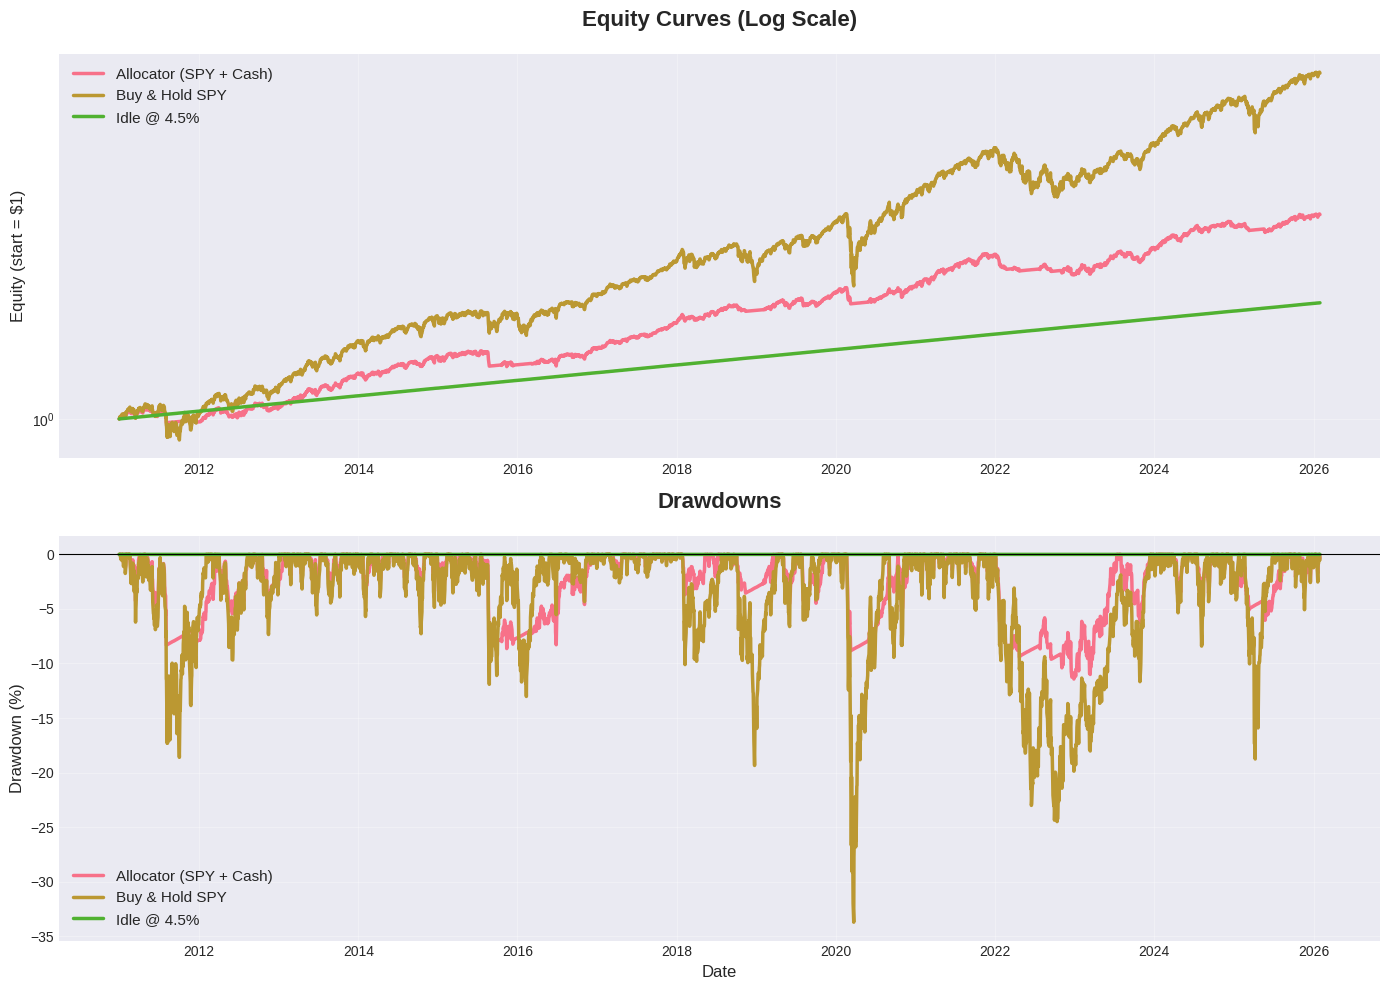

📊 Charts rendered above


In [ ]:
# Equity curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Equity curves (log scale)
for name, returns in strategies.items():
    eq = equity_curve(returns)
    ax1.plot(eq.index, eq.values, label=name, linewidth=2.5)

ax1.set_yscale('log')
ax1.set_title('Equity Curves (Log Scale)', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Equity (start = $1)', fontsize=12)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom: Drawdowns
for name, returns in strategies.items():
    eq = equity_curve(returns)
    dd = drawdown_curve(eq)
    ax2.plot(dd.index, dd.values * 100, label=name, linewidth=2.5)

ax2.set_title('Drawdowns', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='lower left', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

print("📊 Charts rendered above")

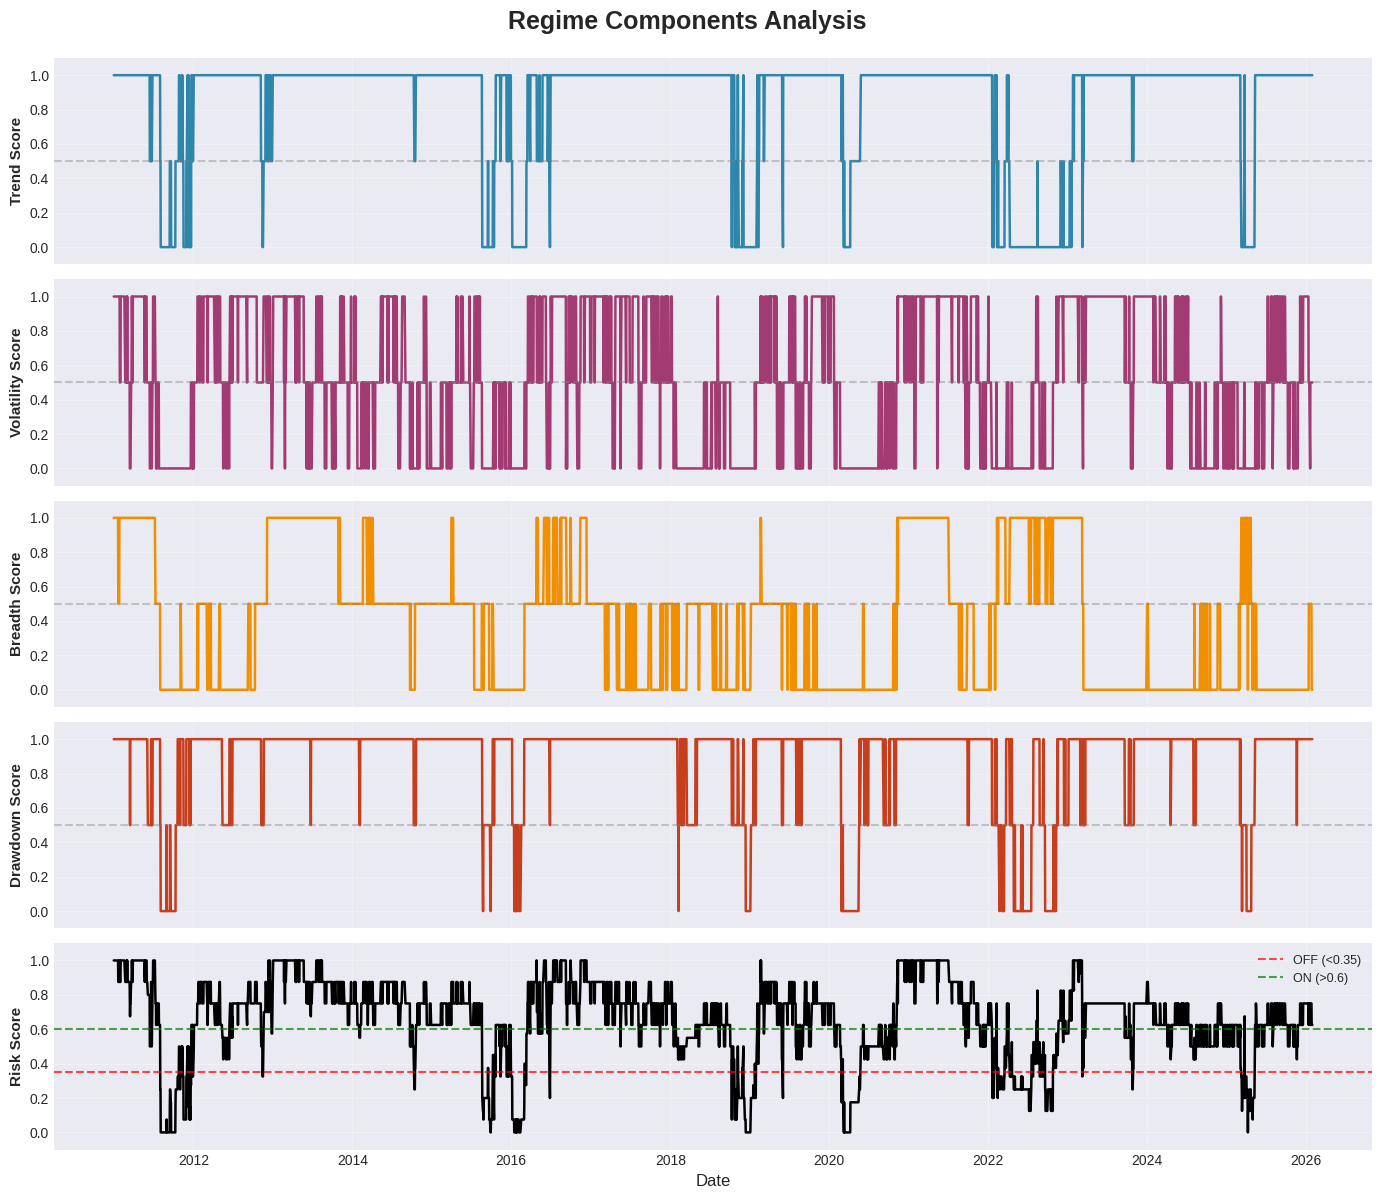

📊 Component analysis rendered above


In [ ]:
# Regime components
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

components = ['trend', 'vol', 'breadth', 'drawdown', 'risk_score']
titles = ['Trend Score', 'Volatility Score', 'Breadth Score', 'Drawdown Score', 'Risk Score']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#000000']

for i, (comp, title, color) in enumerate(zip(components, titles, colors)):
    axes[i].plot(regime.index, regime[comp], linewidth=1.8, color=color)
    axes[i].set_ylabel(title, fontsize=11, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-0.1, 1.1)

    if comp != 'risk_score':
        axes[i].axhline(y=0.5, color='gray', linestyle='--', alpha=0.4)
    else:
        axes[i].axhline(y=OFF_THRESHOLD, color='red', linestyle='--',
                       alpha=0.7, linewidth=1.5, label=f'OFF (<{OFF_THRESHOLD})')
        axes[i].axhline(y=ON_THRESHOLD, color='green', linestyle='--',
                       alpha=0.7, linewidth=1.5, label=f'ON (>{ON_THRESHOLD})')
        axes[i].legend(loc='upper right', fontsize=9)

axes[4].set_xlabel('Date', fontsize=12)
fig.suptitle('Regime Components Analysis', fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("📊 Component analysis rendered above")

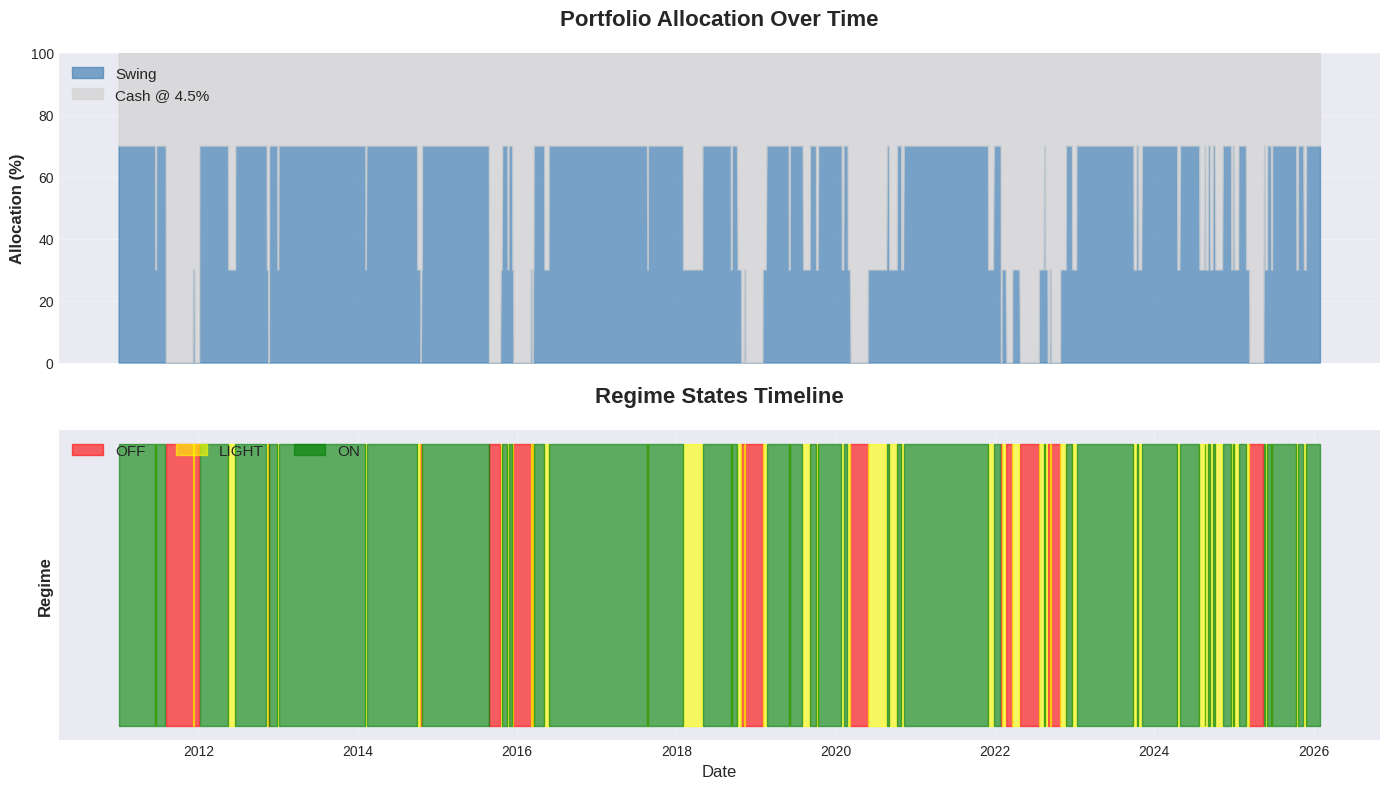

📊 Allocation & regime timeline rendered above


In [ ]:
# Regime timeline with allocation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Allocation
cash_weight = 1 - weights
ax1.fill_between(weights.index, 0, weights.values * 100,
                alpha=0.7, label='Swing', color='steelblue')
ax1.fill_between(weights.index, weights.values * 100, 100,
                alpha=0.7, label='Cash @ 4.5%', color='lightgray')
ax1.set_ylabel('Allocation (%)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_title('Portfolio Allocation Over Time', fontsize=16, fontweight='bold', pad=20)

# Bottom: Regime states
colors_map = {'OFF': 'red', 'LIGHT': 'yellow', 'ON': 'green'}

for state, color in colors_map.items():
    mask = regime['state'] == state
    ax2.fill_between(regime.index, 0, 1, where=mask,
                    alpha=0.6, color=color, label=state)

ax2.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_yticks([])
ax2.legend(loc='upper left', fontsize=11, ncol=3)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_title('Regime States Timeline', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("📊 Allocation & regime timeline rendered above")

# Section 8: Current Regime Check

What's the regime saying RIGHT NOW?

In [ ]:
# Get latest regime info
latest = regime.iloc[-1]
current_state = latest['state']
current_score = latest['risk_score']
current_date = regime.index[-1]

components_current = {
    'Trend': latest['trend'],
    'Volatility': latest['vol'],
    'Breadth': latest['breadth'],
    'Drawdown': latest['drawdown']
}

allocation = ALLOC_MAP[current_state]

# Display
print("="*60)
print("🏔️  CURRENT REGIME STATUS")
print("="*60)
print(f"\n📅 As of: {current_date.date()}")
print(f"\n{'='*60}")

# State with emoji
emoji = {"OFF": "🔴", "LIGHT": "🟡", "ON": "🟢"}[current_state]
print(f"\n{emoji} Current Regime: {current_state}")
print(f"\n📊 Risk Score: {current_score:.3f}")

# Component breakdown
print(f"\n{'='*60}")
print("Component Scores:")
print(f"{'='*60}")
for comp, score in components_current.items():
    bar = "█" * int(score * 20)
    print(f"  {comp:12s}: {score:.2f}  {bar}")

# Allocation recommendation
print(f"\n{'='*60}")
print("Target Allocation:")
print(f"{'='*60}")
print(f"  Swing: {allocation*100:.0f}%")
print(f"  Cash:  {(1-allocation)*100:.0f}%")

# Interpretation
print(f"\n{'='*60}")
print("INTERPRETATION")
print(f"{'='*60}")

if current_state == 'OFF':
    print("\n⛔ RISK-OFF: Market conditions are poor")
    print("   → Stay in cash (4.5% yield)")
    print("   → No new swing positions")
    print("   → Day trading capital reduced to minimum")
    print("   → Like staying off the trail when it's too sketchy")

elif current_state == 'LIGHT':
    print("\n⚠️  RISK-LIGHT: Market conditions are mixed")
    print("   → Deploy limited swing capital (30%)")
    print("   → Be selective with new positions")
    print("   → Favor high-quality setups only")
    print("   → Like choosing your lines carefully on variable terrain")

else:  # ON
    print("\n✅ RISK-ON: Market conditions are favorable")
    print("   → Deploy full swing capital (70%)")
    print("   → Normal position sizing")
    print("   → Can take calculated risks")
    print("   → Like full send mode when trail conditions are perfect")

print(f"\n{'='*60}")

# Recent regime changes
recent_30 = regime.tail(30)
state_changes = (recent_30['state'] != recent_30['state'].shift()).sum()

print(f"\n📈 Regime stability: {state_changes} changes in last 30 days")
if state_changes > 5:
    print("   ⚠️  Choppy regime - consider increasing HYSTERESIS_DAYS")
elif state_changes <= 2:
    print("   ✅ Stable regime - good for conviction")

print()

🏔️  CURRENT REGIME STATUS

📅 As of: 2026-01-30


🟢 Current Regime: ON

📊 Risk Score: 0.625

Component Scores:
  Trend       : 1.00  ████████████████████
  Volatility  : 0.50  ██████████
  Breadth     : 0.00  
  Drawdown    : 1.00  ████████████████████

Target Allocation:
  Swing: 70%
  Cash:  30%

INTERPRETATION

✅ RISK-ON: Market conditions are favorable
   → Deploy full swing capital (70%)
   → Normal position sizing
   → Can take calculated risks
   → Like full send mode when trail conditions are perfect


📈 Regime stability: 1 changes in last 30 days
   ✅ Stable regime - good for conviction



# Section 9: Next Steps

What to do with this system.

In [ ]:
print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                           🎯 NEXT STEPS                                    ║
╚════════════════════════════════════════════════════════════════════════════╝

✅ You've completed the backtest!

═══════════════════════════════════════════════════════════════════════════
IMMEDIATE (This Week)
═══════════════════════════════════════════════════════════════════════════

1. Save This Notebook
   □ File → Save a copy in Drive
   □ Opens automatically next time

2. Review Results
   □ Do regime states make intuitive sense?
   □ Is the trade-off (CAGR vs drawdown) acceptable?

3. Adjust Parameters (Section 2)
   □ If too conservative → lower thresholds
   □ If too aggressive → raise thresholds
   □ Re-run and compare

4. Daily Check (30 sec)
   □ Open notebook
   □ Runtime → Run all
   □ Scroll to Section 8 (Current Regime)

═══════════════════════════════════════════════════════════════════════════
SHORT TERM (Weeks 2-4)
═══════════════════════════════════════════════════════════════════════════

5. Paper Trade
   □ Run Section 8 daily
   □ Log: Date | State | Score
   □ Build confidence in signals
   □ DON'T trade real money yet

6. For Production
   □ Download full system: personal_cio.tar.gz
   □ Read INTEGRATION_PLAN.md (12-week rollout)
   □ Set up automation

═══════════════════════════════════════════════════════════════════════════
CAPITAL ARCHITECTURE
═══════════════════════════════════════════════════════════════════════════

Your three modes:

┌─────────────────────────────────────────────────────────────┐
│ Day Trading - Fixed allocation                              │
│   → Your discretionary edge                                 │
│   → NOT governed by regime                                  │
├─────────────────────────────────────────────────────────────┤
│ Swing Book - Regime-governed                                │
│   → OFF: 0% deployed                                        │
│   → LIGHT: 30% deployed                                     │
│   → ON: 70% deployed                                        │
├─────────────────────────────────────────────────────────────┤
│ Idle Cash - Strategic                                       │
│   → 4.5% yield                                              │
│   → NOT dead money                                          │
└─────────────────────────────────────────────────────────────┘

═══════════════════════════════════════════════════════════════════════════
WARNINGS
═══════════════════════════════════════════════════════════════════════════

❌ Don't override regime signals
❌ Don't trade before Week 11
❌ Don't expect maximum CAGR

🏔️  Remember: This is a weather station, not a trail guide.

Boring = Success.

╚════════════════════════════════════════════════════════════════════════════╝
""")


╔════════════════════════════════════════════════════════════════════════════╗
║                           🎯 NEXT STEPS                                    ║
╚════════════════════════════════════════════════════════════════════════════╝

✅ You've completed the backtest!

═══════════════════════════════════════════════════════════════════════════
IMMEDIATE (This Week)
═══════════════════════════════════════════════════════════════════════════

1. Save This Notebook
   □ File → Save a copy in Drive
   □ Opens automatically next time

2. Review Results
   □ Do regime states make intuitive sense?
   □ Is the trade-off (CAGR vs drawdown) acceptable?

3. Adjust Parameters (Section 2)
   □ If too conservative → lower thresholds
   □ If too aggressive → raise thresholds
   □ Re-run and compare

4. Daily Check (30 sec)
   □ Open notebook
   □ Runtime → Run all
   □ Scroll to Section 8 (Current Regime)

═══════════════════════════════════════════════════════════════════════════
SHORT TERM (Weeks